In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
# ### get data (set config params)
# ticker_list = ["BTCUSDT"]
# start_date = "2022-02-03"
# end_date = "2022-02-04"
# time_interval = "1s"

# p = BinanceProcessor("binance")
# df = p.download_data(ticker_list, start_date, end_date, time_interval)

In [16]:
def stationize(series):
    return np.log(series / series.shift(1))

In [17]:
# df.drop('tic', axis=1, inplace=True)
# df['log_ret'] = stationize(df['close'])
# df.drop(["open","high","low", "volume"], axis=1, inplace=True)
# df.head()

In [18]:
# df.to_csv('always.csv')

### NOW WE JUST READ IN FROM CSV BRUH

In [19]:
df = pd.read_csv('always.csv', index_col=0)

In [20]:
df

,close,log_ret
2022-02-03 00:00:00,36902.96,NaN
2022-02-03 00:00:01,36902.81,-0.000004
2022-02-03 00:00:02,36899.19,-0.000098
2022-02-03 00:00:03,36900.54,0.000037
2022-02-03 00:00:04,36895.62,-0.000133
...,...,...
2022-02-04 23:59:55,41545.77,-0.000261
2022-02-04 23:59:56,41549.21,0.000083
2022-02-04 23:59:57,41545.98,-0.000078
2022-02-04 23:59:58,41552.02,0.000145


In [21]:
from ue.uexp.models.util import WindowGenerator

In [22]:
a = WindowGenerator(df)

In [23]:
single_step_window = WindowGenerator(df,
    back_window=1, forward_window=1, forward_horizon=1,
    label_columns=['log_ret'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]

In [24]:
for example_inputs, example_labels in single_step_window.train_ds.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 2)
Labels shape (batch, time, features): (32, 1, 1)


In [25]:
single_step_window.plot_preds()

TypeError: plot_preds() missing 1 required positional argument: 'model'

## MLP

In [26]:
PAST_VIEW_WINDOW = 30
conv_window = WindowGenerator(df, 
    back_window=PAST_VIEW_WINDOW,
    forward_window=60,
    forward_horizon=1,
    label_columns=['log_ret'])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30]

In [27]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [45]:
#compile and fit
MAX_EPOCHS = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

multi_step_dense.compile(loss="mae",
            optimizer=tf.optimizers.Adam(),
            metrics=['mse','mape','mae'])

history = multi_step_dense.fit(a.train_ds, epochs=MAX_EPOCHS,
                      validation_data=a.val_ds,
                      callbacks=[early_stopping])

Epoch 1/5
  16/3780 [..............................] - ETA: 26s - loss: 18498.3125 - mse: 684446400.0000 - mape: 5296774.5000 - mae: 18498.3125 

2022-02-10 12:59:37.494409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3780/3780 [==============================] - ETA: 0s - loss: 18502.9004 - mse: 684798912.0000 - mape: 4794059.0000 - mae: 18502.9004

2022-02-10 13:00:01.011814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3780/3780 [==============================] - 27s 7ms/step - loss: 18502.9004 - mse: 684798912.0000 - mape: 4794059.0000 - mae: 18502.9004 - val_loss: 19398.7559 - val_mse: 753273920.0000 - val_mape: 3758710.2500 - val_mae: 19398.7559
Epoch 2/5
3780/3780 [==============================] - 27s 7ms/step - loss: 18502.9277 - mse: 684800000.0000 - mape: 4794059.0000 - mae: 18502.9277 - val_loss: 19398.7598 - val_mse: 753273216.0000 - val_mape: 3758714.5000 - val_mae: 19398.7598
Epoch 3/5
3780/3780 [==============================] - 27s 7ms/step - loss: 18502.9336 - mse: 684799232.0000 - mape: 4794059.0000 - mae: 18502.9336 - val_loss: 19398.7637 - val_mse: 753273856.0000 - val_mape: 3758716.0000 - val_mae: 19398.7637


In [46]:
preds = multi_step_dense.predict(a.test_ds)

2022-02-10 13:01:53.643470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

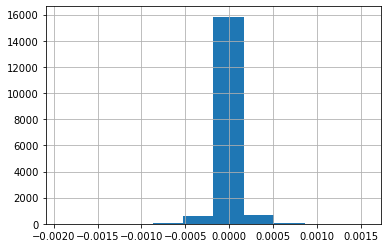

In [63]:
a.test_df['log_ret'].hist()

In [49]:
preds

array([[[0.02937706]],

       [[0.02937706]],

       [[0.02937706]],

       ...,

       [[0.02937706]],

       [[0.02937706]],

       [[0.02937706]]], dtype=float32)

In [47]:
preds.shape

(17250, 1, 1)

In [35]:
len(a.test_ds)

540

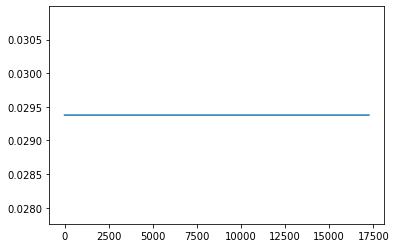

In [48]:
plt.plot(np.ravel(preds))

In [13]:
PAST_VIEW_WINDOW = 30
prof_window = WindowGenerator(df, 
    back_window=PAST_VIEW_WINDOW,
    forward_window=60,
    forward_horizon=1,
    label_columns=['log_ret'])

conv_window

AttributeError: 'WindowGenerator' object has no attribute 'plot'

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=df['log_ret'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val_ds)
performance['Baseline'] = baseline.evaluate(single_step_window.test_ds, verbose=0)

The WindowGenerator has a plot method, but the plots won't be very interesting with only a single sample.

So, create **a wider WindowGenerator that generates windows 24 hours of consecutive inputs and labels at a time**. The new wide_window variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the time axis acts like the batch axis: each prediction is made independently with no interaction between time steps:

In [ ]:
wide_window = WindowGenerator(df,
    back_window=24, forward_window=24, forward_horizon=1,
    label_columns=['log_ret'])

wide_window

In [ ]:
wide_window.plot(baseline)